<a href="https://colab.research.google.com/github/simha13/Digit-Recognition-using-DTW/blob/main/Term_Project_EC864_(Revised).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Function to read .wav file**

In [ ]:
import wave
import numpy as np
import pylab as pl

def wavread(filename):
    # Read wav file
    print('Reading WAV file  ',filename,'---\n')
    wavefile = wave.open(filename, 'r')

    #Function to read four types of information from wav files. numframes indicates how many frames were read in total
    nchannels = wavefile.getnchannels()             # Returns number of audio channels (1 for mono, 2 for stereo).
    sample_width = wavefile.getsampwidth()          # Returns sample width in bytes.
    framerate = wavefile.getframerate()             # Returns sampling frequency.
    numframes = wavefile.getnframes()               # Returns number of audio frames.

    #print("channel",nchannels)
    #print("sample_width",sample_width)
    #print("framerate",framerate)
    #print("numframes",numframes)

    str_data = wavefile.readframes(numframes)       # Reads and returns at most n frames of audio, as a bytes object.
    wavefile.close()

    #Convert waveform data to array
    wave_data = np.fromstring(str_data, dtype=np.short)
    #print(len(wave_data))
    time = np.arange(0, numframes) * (1.0 / framerate)
    #print(len(time))

    return wave_data

### **Pre-emphasis**

In [ ]:
def pre_emphasis(signal,coefficient=0.95):
    '''
    Pre-emphasize the signal
    Parameter meaning:-
    signal: original signal
    coefficient: emphasis coefficient, default is 0.95
    '''
    print('Pre emphasis \n')
    return numpy.append(signal[0],signal[1:]-coefficient*signal[:-1])

### **Signal framing and windowing**

In [ ]:
def enframe(signal, nw, inc, winfunc):
    '''
    Convert audio signals into frames.
    Parameter meaning:
    signal:original audio model
    nw: The length of each frame (here refers to the length of the sampling point, that is, the sampling frequency multiplied by the time interval)
    inc: interval between adjacent frames (same as defined above)
    '''
    print('Signal framing and windowing \n')
    signal_length=len(signal) #total signal length
    if signal_length<=nw: #If the signal length is less than the length of one frame, the number of frames is defined as 1
        nf=1
    else: #Otherwise, calculate the total length of the frame
        nf=int(np.ceil((1.0*signal_length-nw+inc)/inc))
    pad_length=int((nf-1)*inc+nw) #The total flattened length of all frames added up
    zeros=np.zeros((pad_length-signal_length,)) #Insufficient lengths are padded with 0s, similar to the extended array operation in FFT.
    pad_signal=np.concatenate((signal,zeros)) #The padded signal is recorded as pad_signal
    indices=np.tile(np.arange(0,nw),(nf,1))+np.tile(np.arange(0,nf*inc,inc),(nw,1)).T  #It is equivalent to extracting the time points of all frames to obtain a matrix of nf*nw length.
    indices=np.array(indices,dtype=np.int32) #Convert indices into matrices
    frames=pad_signal[indices] #Get frame signal
    win=np.tile(winfunc,(nf,1))  #window window function, the default value here is 1
    #print(np.shape(frames*win))
    return frames*win   #Return frame signal matrix

In [ ]:
def sgn(n):                     # Returns the sign of frames, used in ZCR Calculation
    if n>=0:
        return 1
    if n<0:
        return -1

def energy(frames):
    #print(frames)
    frames=frames/np.amax(np.absolute(frames))  # classified as [-1,1]
    nframe=np.shape(frames)[0]                  # Number of frames
    lframe=np.shape(frames)[1]                  # Energy of frames
    energy=np.power(frames,2)                   # Sum energy along each frame
    e=energy.sum(axis=1)
    time = np.arange(0, nframe)
    pl.plot(time,e)
    pl.xlabel("Time")
    pl.ylabel("Energy of signal")
    pl.show()
    return e

def zcr(frames):
    nframe=np.shape(frames)[0]                   # Number of frames
    lframe=np.shape(frames)[1]                   # Length of each frame
    zcr=np.zeros(nframe)                         # Initialize zero crossing rate array
    for i in range(nframe):
        zframe=0
        for j in range(1,lframe):
            zframe=zframe+0.5*(abs(sgn(frames[i,j])-sgn(frames[i,j-1])))
        zcr[i]=zframe/(lframe-1)                 # Compute zero crossing rate for each frame
    time = np.arange(0, nframe)
    pl.plot(time,zcr)
    pl.xlabel("Time")
    pl.ylabel("Zero crossing Rate")
    pl.show()
    return zcr

def vioceextrac(frames):
    print('Extracting active voice \n')
    nframe=np.shape(frames)[0]                    # Number of frames
    lframe=np.shape(frames)[1]
    mh=10                                         # High energy threshold
    ml=2                                          # Low energy threshold
    zs=0.18                                       # Zero crossing rate threshold
    a1=0
    a2=0
    status=0
    count=0                                       # This variable counts the number of consecutive frames with energy levels below mh to determine the end of an active voice segment.
    e=energy(frames)                              # Compute energy of frames
    z=zcr(frames)                                 # Compute zero crossing rate of frames
    mh=min(mh,np.amax(e)/4)                       # Adjust high energy threshold
    ml=min(ml,np.amax(e)/8)                       # Adjust low energy threshold
    #print(mh,ml)
    for i in range(nframe):                       # a1, a2, a2t: These variables are used to track the indices of frames where active voice starts (a1) and ends (a2). a2t is a temporary variable used during the process.
        if status==0 and e[i]>mh:
            a1=i
            status=1
        if status==1 and e[i]<mh:
            a2t=i
            status=2
        if status==2 and e[i]<mh:
            count=count+1
        if status==2 and e[i]>mh:
            count=0
            status=1
        if status==2 and count>30:
            a2=a2t
    #print(a1,a2)
    b1=a1-1                                       # b1, b2: These variables are used to adjust the boundaries of the active voice segment by considering energy levels. They are derived from a1 and a2.
    b2=a2+1
    while e[b1]>ml:
        b1=b1-1
    while e[b2]>ml:
        b2=b2+1
    #print(b1,b2)
    c1=b1-1                                      # c1, c2: These variables are used to further refine the boundaries of the active voice segment by considering both energy levels (ml) and zero crossing rates (zs). They are derived from b1 and b2.
    c2=b2+1
    while z[c1]>=(3*zs):                         # status: This variable tracks the current state of processing the frames. It transitions between different states based on energy levels to detect the start and end of active voice segments.
        c1=c1-1
    while z[c2]>=(3*zs):
        c2=c2+1
    #print(c1,c2)
    frames_a=frames[c1:c2,:]
    return(frames_a)                             # Return frames containing active voice segments

### **Feature Extraction (using MFCC)**

In [ ]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct

def mfcc(frames,NFFT=512,sample_rate=16000):
    print('Computing MFCC features \n')
    #frame energy spectrum
    mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    energy=numpy.sum(pow_frames,1)  #Sum the energy spectrum of each frame
    energy=numpy.where(energy==0,numpy.finfo(float).eps,energy)  #Adjust the places where the energy is 0 to eps, which facilitates logarithmic processing.
    #print(numpy.shape(mag_frames),numpy.shape(pow_frames))
    #filter bank
    nfilt=40

    low_freq_mel = 0
    high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = numpy.dot(pow_frames, fbank.T)
    filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * numpy.log10(filter_banks)  # dB

    #mfcc
    num_ceps = 13
    appendEnergy=1

    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
    if appendEnergy:
        mfcc[:,0]=numpy.log(energy)  #Take only 2-13 coefficients and replace the first one with the logarithm of the energy
    #mean-normalized
    mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)


    return mfcc_delta_delta(mfcc)

def derivate(feat,big_theta=2,cep_num=13):
    '''General transformation formula for calculating first-order coefficients or acceleration coefficients
    Parameter Description:
    feat: MFCC array or first-order coefficient array
    big_theta: the big theta in the formula, the default is 2. This parameter controls the range of the calculation
    '''
    result=numpy.zeros(feat.shape) #result
    denominator=0  #Denominator
    for theta in numpy.linspace(1,big_theta,big_theta):
        denominator=denominator+theta**2
    denominator=denominator*2 #Calculate the value of the denominator
    for row in numpy.linspace(0,feat.shape[0]-1,feat.shape[0]):
        tmp=numpy.zeros((cep_num,))
        numerator=numpy.zeros((cep_num,)) #numerator
        for t in numpy.linspace(1,cep_num,cep_num):
            a=0
            b=0
            s=0
            for theta in numpy.linspace(1,big_theta,big_theta):
                if (t+theta)>cep_num:
                    a=0
                else:
                    a=feat[int(row)][int(t+theta-1)]
                if (t-theta)<1:
                    b=0
                else:
                    b=feat[int(row)][int(t-theta-1)]
                s+=theta*(a-b)
            numerator[int(t-1)]=s
        tmp=numerator*1.0/denominator
        result[int(row)]=tmp
    return result


def mfcc_delta(feat):
    '''Calculate 13 MFCC+13 first-order differential coefficients
    '''
    result=derivate(feat) #Call the derive function
    result=numpy.concatenate((feat,result),axis=1)
    return result


def mfcc_delta_delta(feat):
    '''Calculate 13 MFCCs + 13 first-order differential coefficients + 13 acceleration coefficients, a total of 39 coefficients
    '''
    result1=derivate(feat)
    result2=derivate(result1)
    result3=numpy.concatenate((feat,result1),axis=1)
    result=numpy.concatenate((result3,result2),axis=1)
    return result

### **DTW Principle**

In [ ]:
import numpy as np

def dist(feat1,feat2):                                                      # Calculates the Euclidean distance between feat1 and feat2
    n=np.shape(feat1)[0]
    m=np.shape(feat2)[0]
    d=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            d[i,j]=np.sqrt(np.sum(np.square(feat1[i,:]-feat2[j,:])))
    return d

def dtw(dist):

    realmax=1.79E+308                                                       # Maximum values of numerical operations
    n=np.shape(dist)[0]
    m=np.shape(dist)[1]                                                     # dimensions of the distance matrix
    D=np.ones((n+1,m+1))*realmax                                            # initializes a matrix D with dimensions (n+1) x (m+1) filled with the maximum value
    D[0,0]=0
    #print(D)                                                            # sets the starting point of the DTW matrix to 0
    for i in range(1,n+1):
        for j in range(1,m+1):
            D[i,j]=dist[i-1,j-1]+min(D[i-1,j],D[i,j-1],D[i-1,j-1])
    return D[n,m]

def score(feat1,feat2):                                                     #   calculates the DTW score (similarity) between two sets of feature vectors
    return dtw(dist(feat1,feat2))

### **Training**

Reading WAV file   /content/drive/MyDrive/train/1a.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



<ipython-input-2-38ef7c5dd080>:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  wave_data = np.fromstring(str_data, dtype=np.short)
<ipython-input-11-ffa5ce279020>:18: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  winfunc = signal.hamming(240)


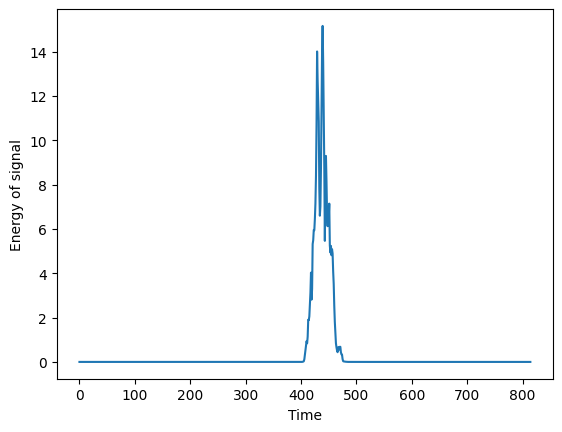

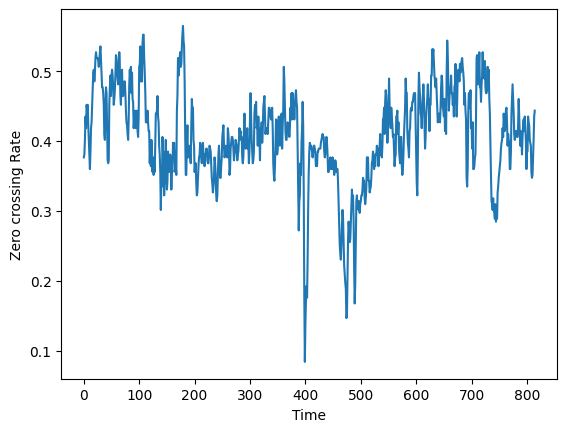

Computing MFCC features 

Output results of /content/drive/MyDrive/train/1a.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/2a.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



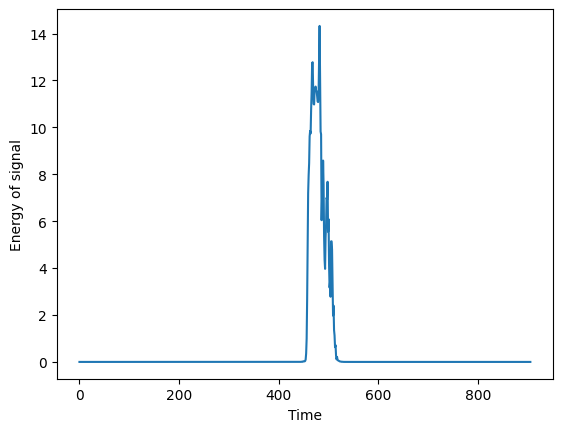

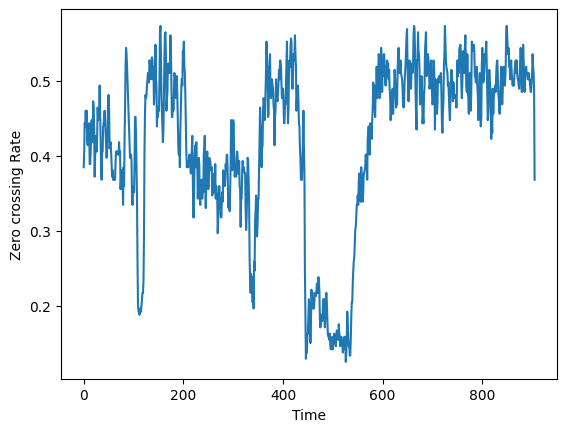

Computing MFCC features 

Output results of /content/drive/MyDrive/train/2a.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/0c.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



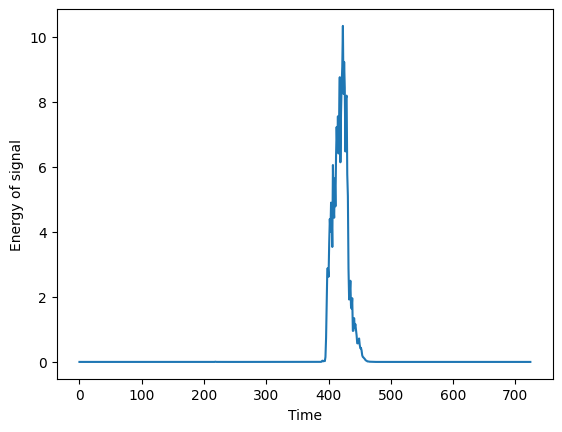

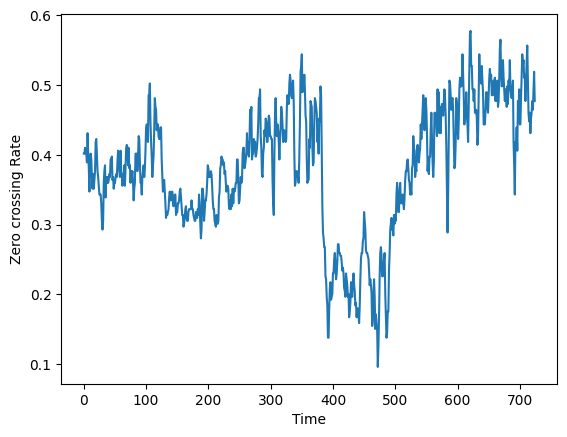

Computing MFCC features 

Output results of /content/drive/MyDrive/train/0c.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/2b.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



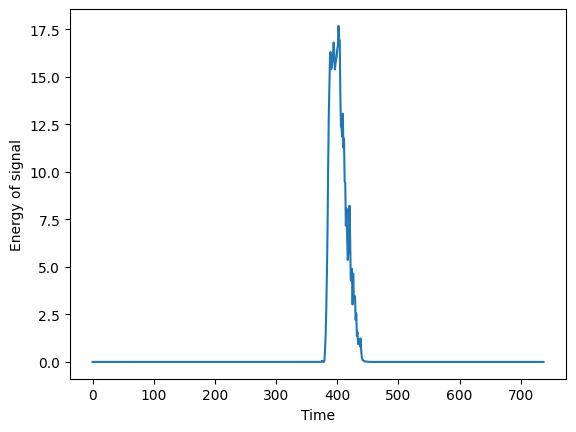

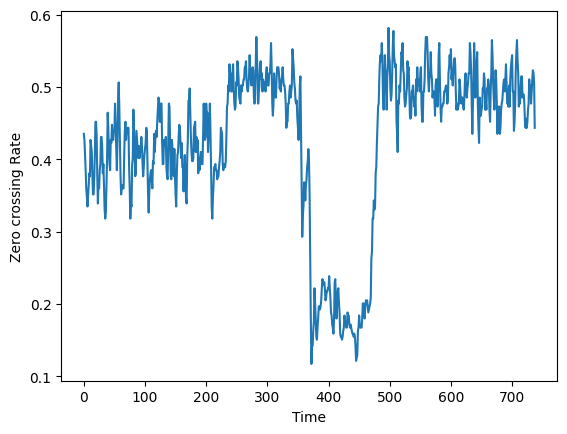

Computing MFCC features 

Output results of /content/drive/MyDrive/train/2b.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/0b.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



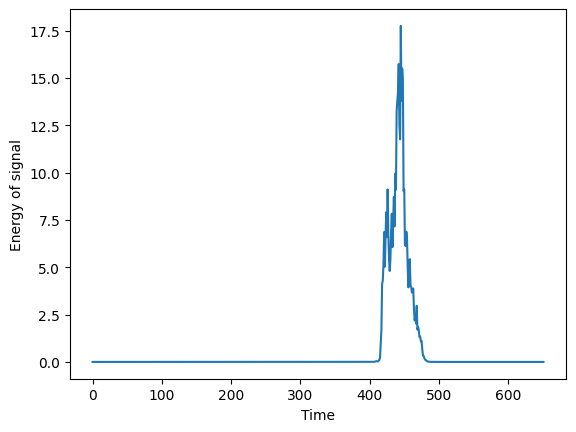

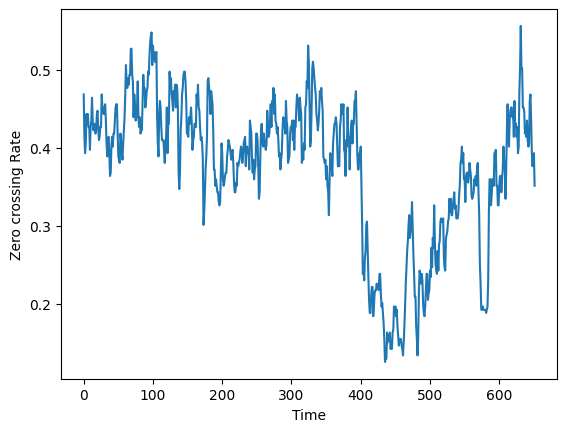

Computing MFCC features 

Output results of /content/drive/MyDrive/train/0b.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/0a.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



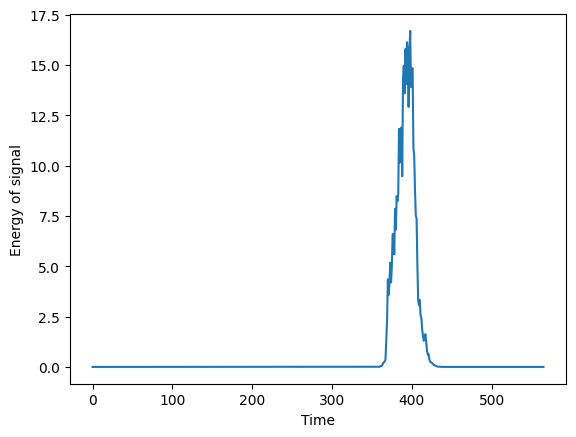

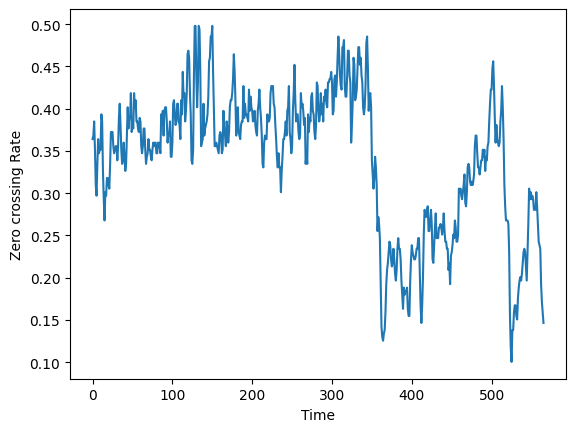

Computing MFCC features 

Output results of /content/drive/MyDrive/train/0a.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/1b.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



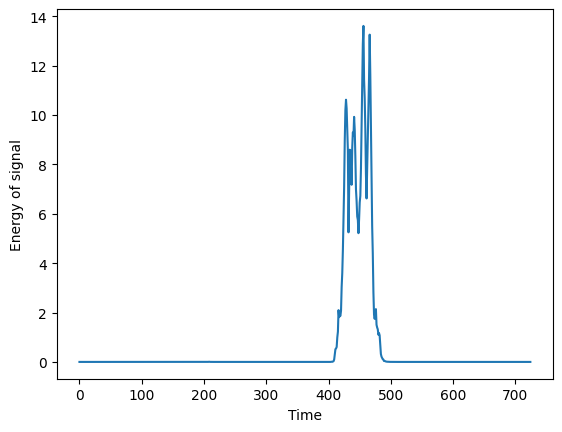

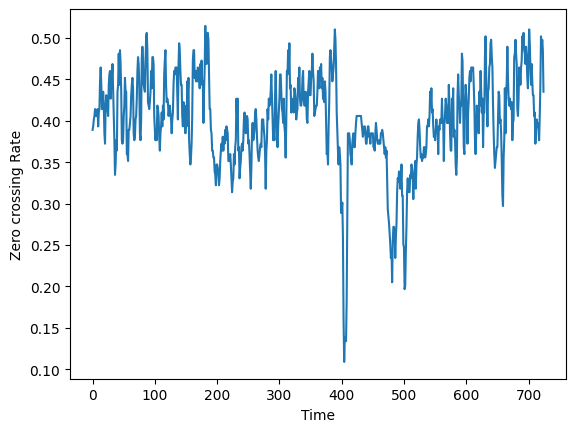

Computing MFCC features 

Output results of /content/drive/MyDrive/train/1b.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/3b.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



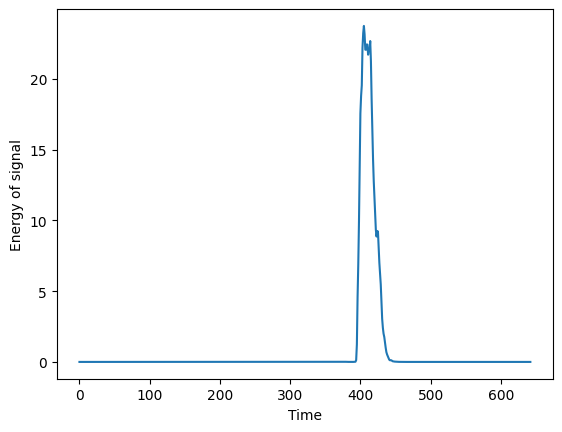

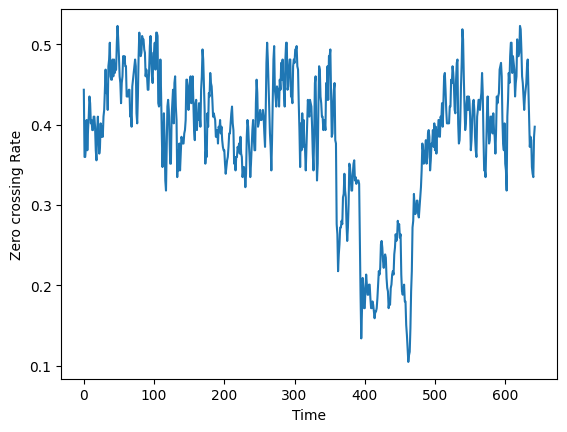

Computing MFCC features 

Output results of /content/drive/MyDrive/train/3b.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/3a.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



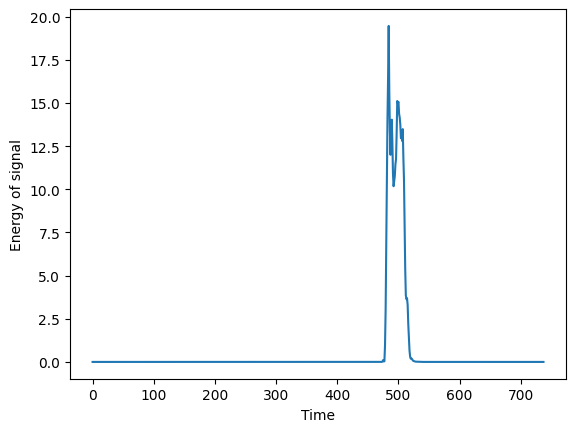

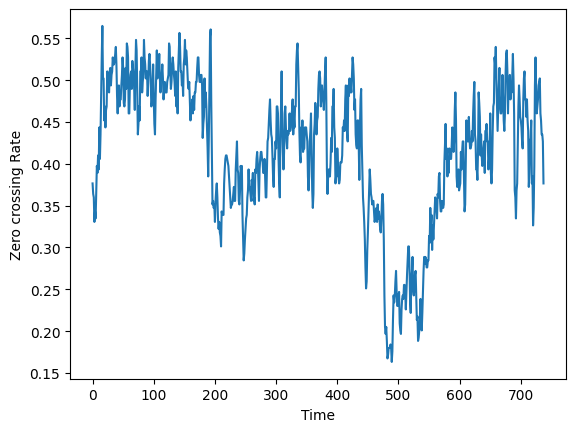

Computing MFCC features 

Output results of /content/drive/MyDrive/train/3a.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/2c.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



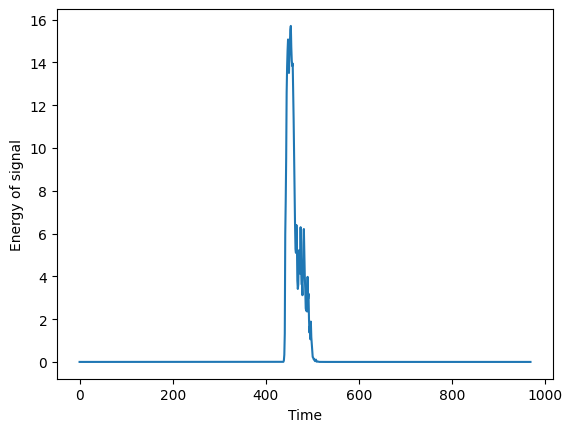

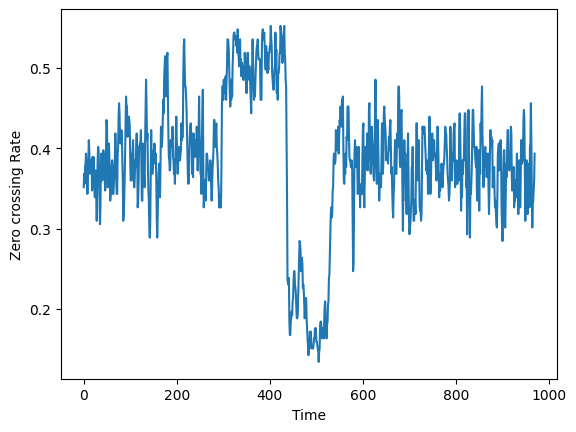

Computing MFCC features 

Output results of /content/drive/MyDrive/train/2c.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/1c.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



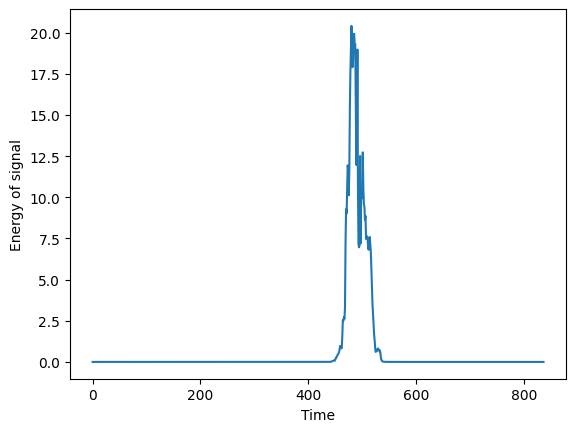

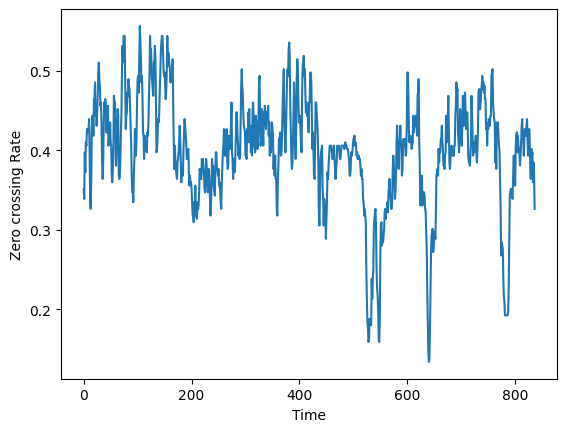

Computing MFCC features 

Output results of /content/drive/MyDrive/train/1c.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/7b.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



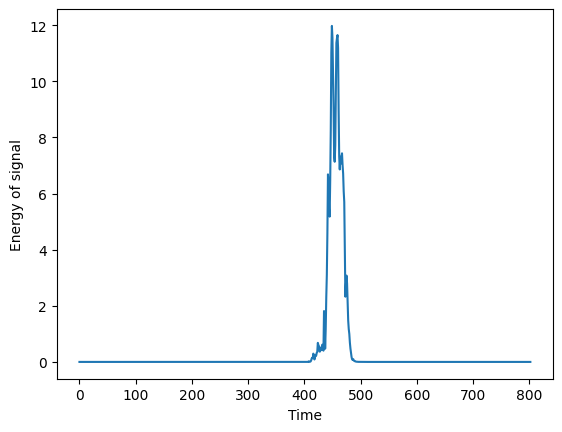

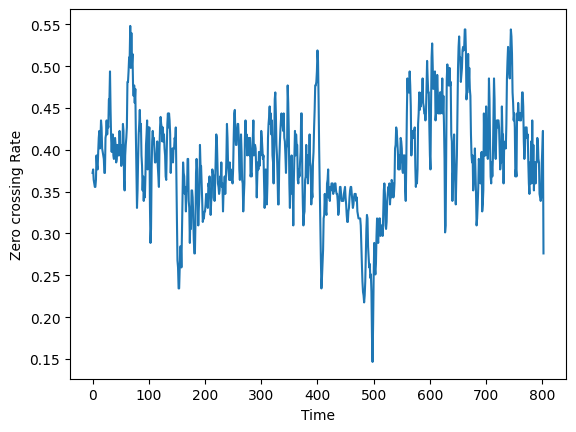

Computing MFCC features 

Output results of /content/drive/MyDrive/train/7b.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/5c.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



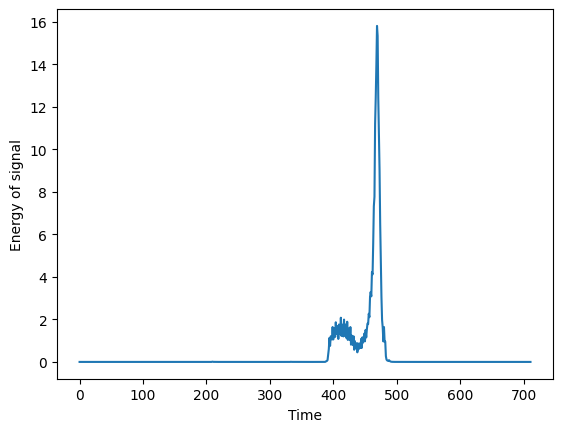

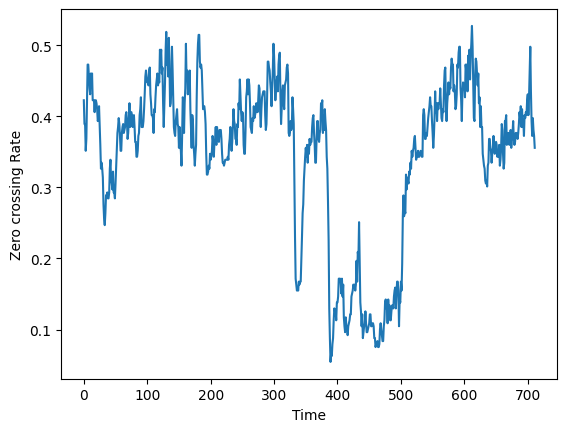

Computing MFCC features 

Output results of /content/drive/MyDrive/train/5c.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/4c.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



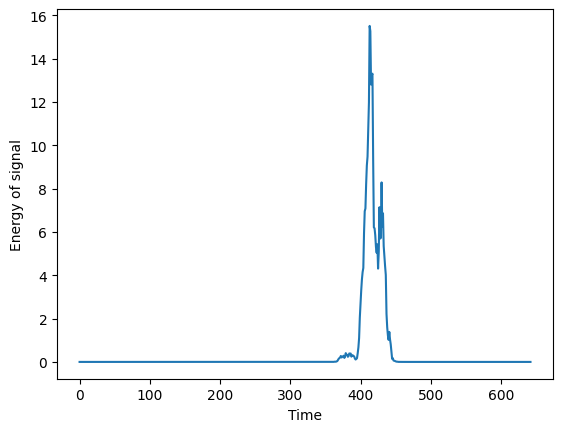

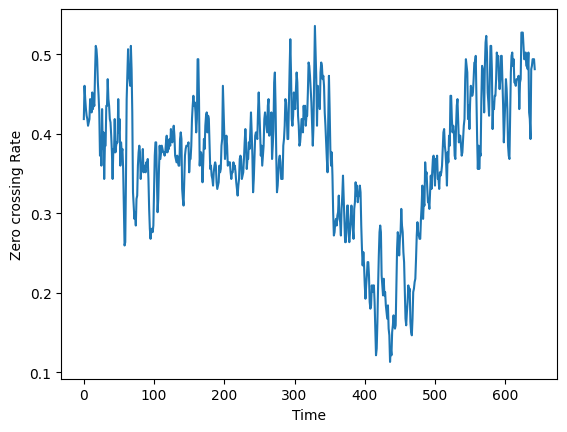

Computing MFCC features 

Output results of /content/drive/MyDrive/train/4c.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/3c.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



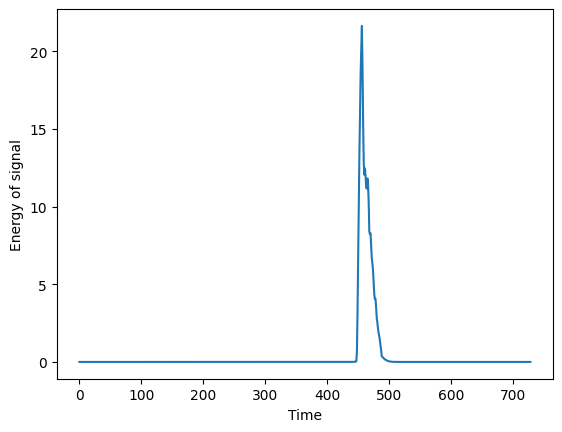

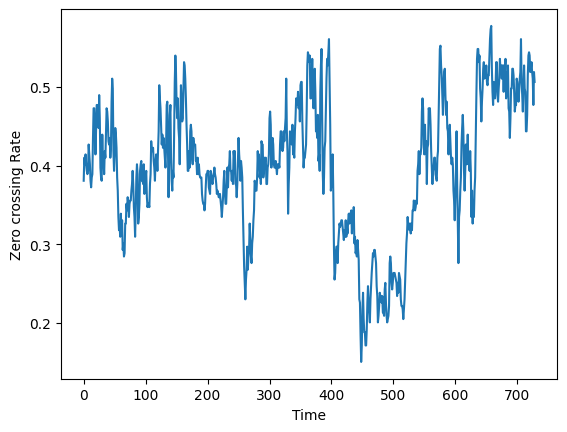

Computing MFCC features 

Output results of /content/drive/MyDrive/train/3c.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/8c.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



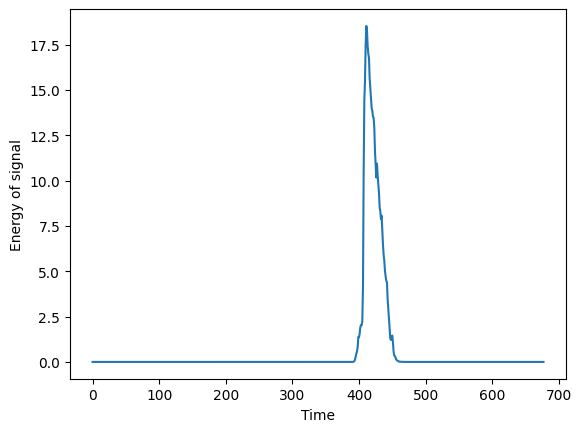

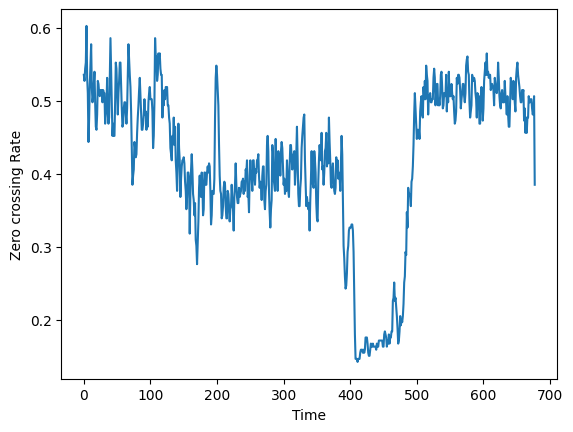

Computing MFCC features 

Output results of /content/drive/MyDrive/train/8c.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/7a.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



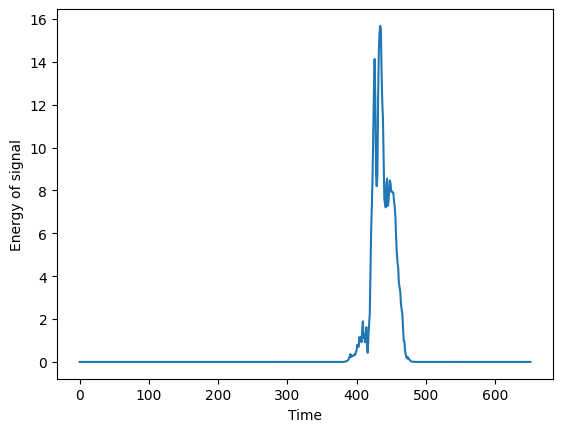

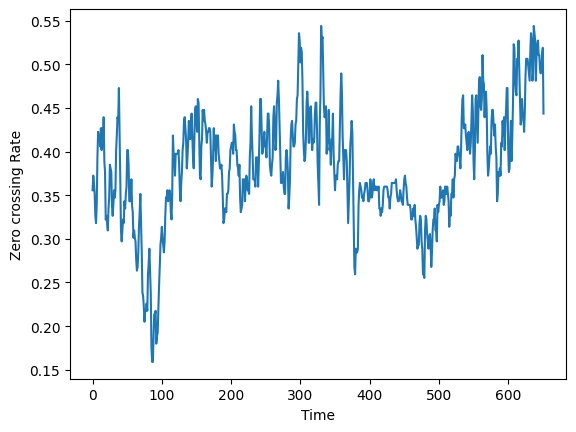

Computing MFCC features 

Output results of /content/drive/MyDrive/train/7a.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/5a.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



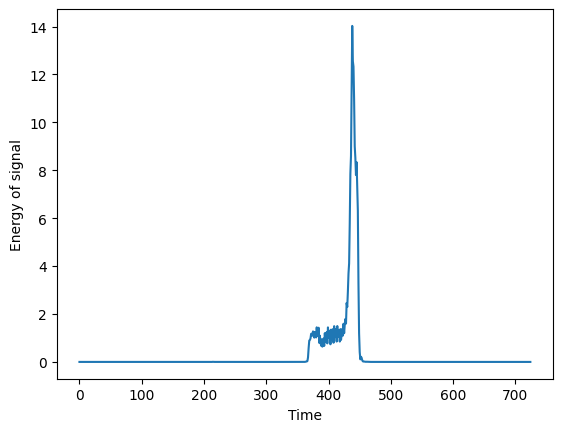

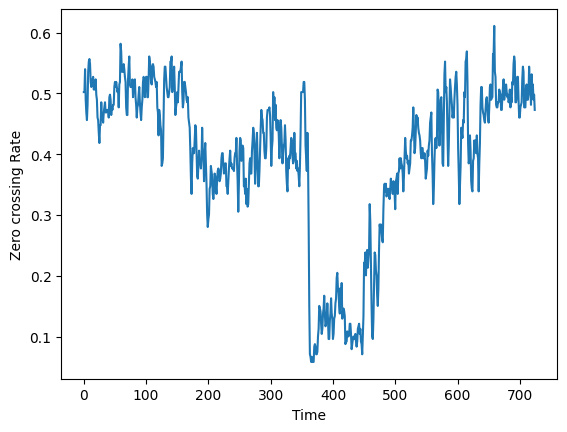

Computing MFCC features 

Output results of /content/drive/MyDrive/train/5a.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/5b.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



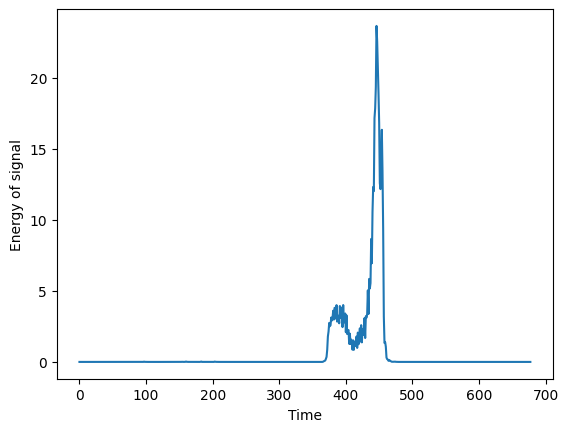

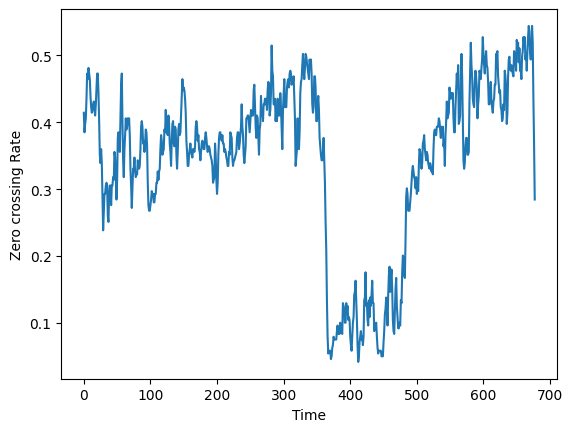

Computing MFCC features 

Output results of /content/drive/MyDrive/train/5b.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/4a.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



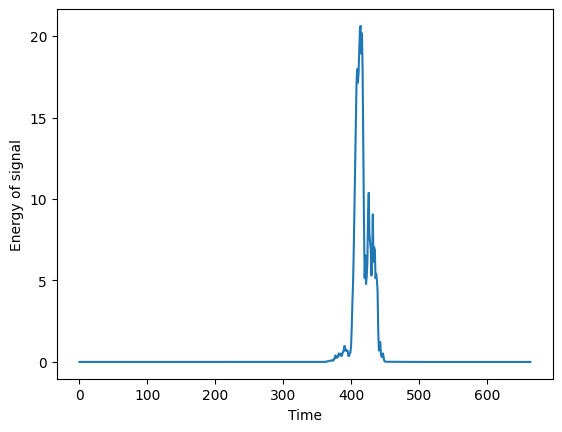

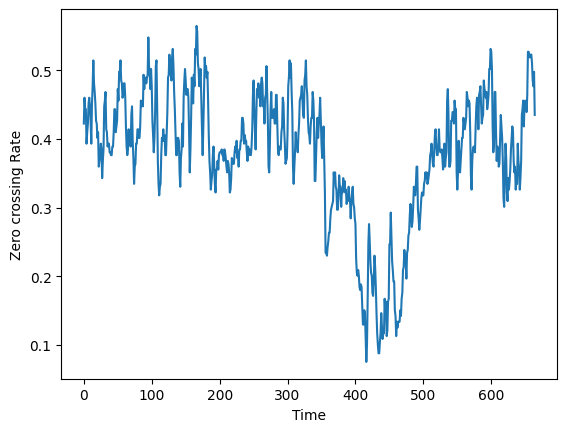

Computing MFCC features 

Output results of /content/drive/MyDrive/train/4a.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/6a.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



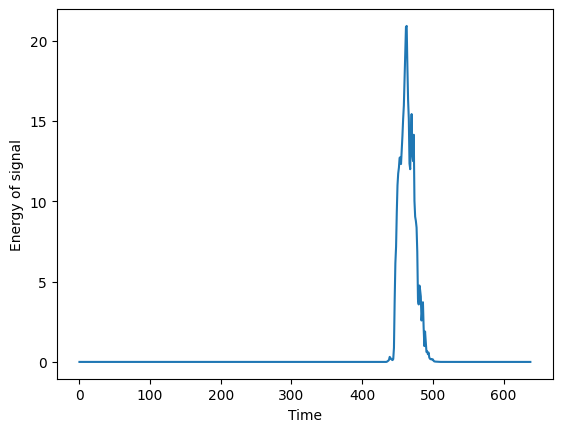

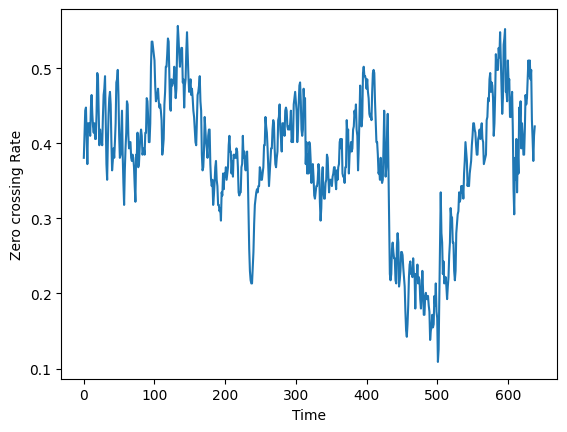

Computing MFCC features 

Output results of /content/drive/MyDrive/train/6a.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/4b.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



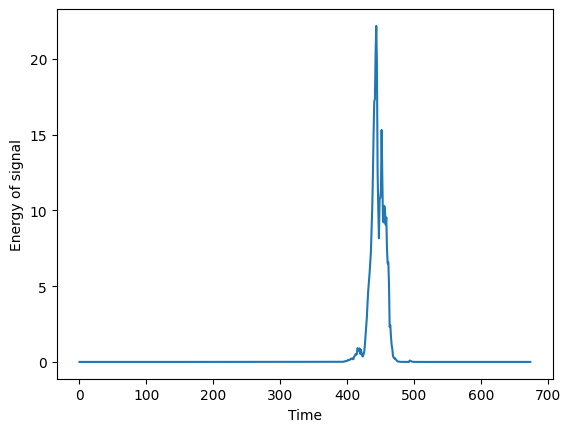

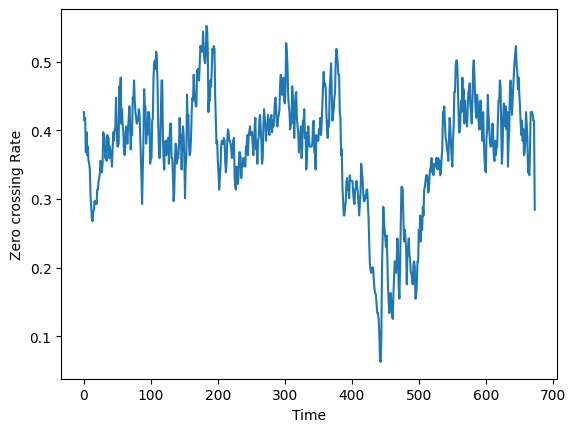

Computing MFCC features 

Output results of /content/drive/MyDrive/train/4b.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/6c.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



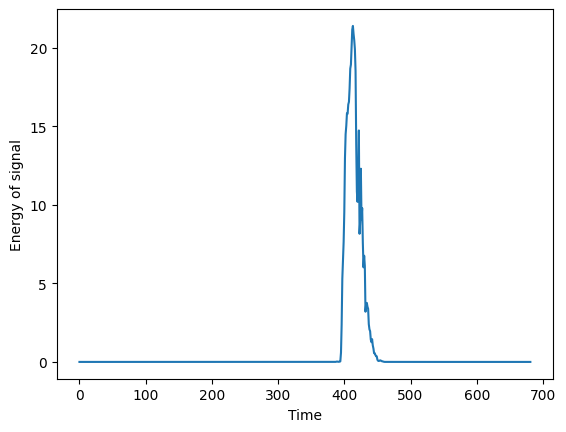

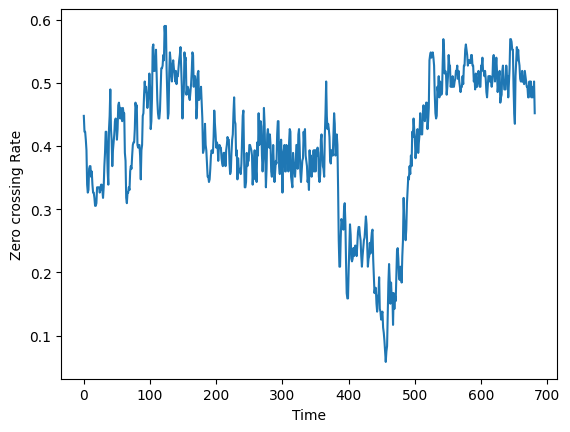

Computing MFCC features 

Output results of /content/drive/MyDrive/train/6c.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/8b.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



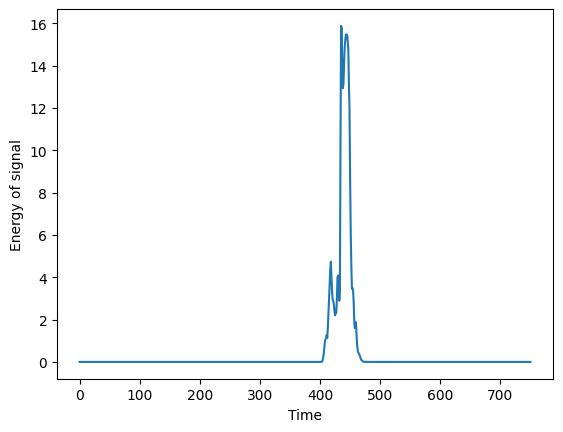

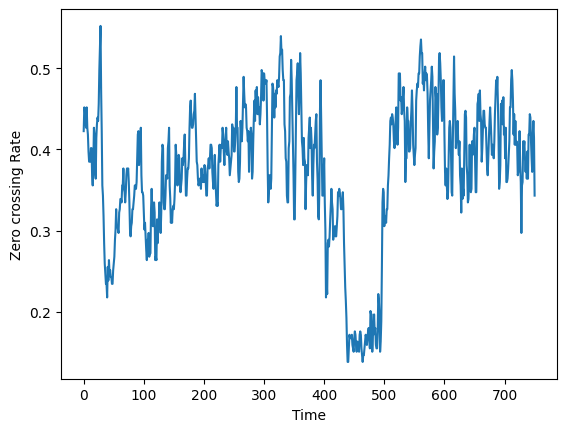

Computing MFCC features 

Output results of /content/drive/MyDrive/train/8b.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/8a.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



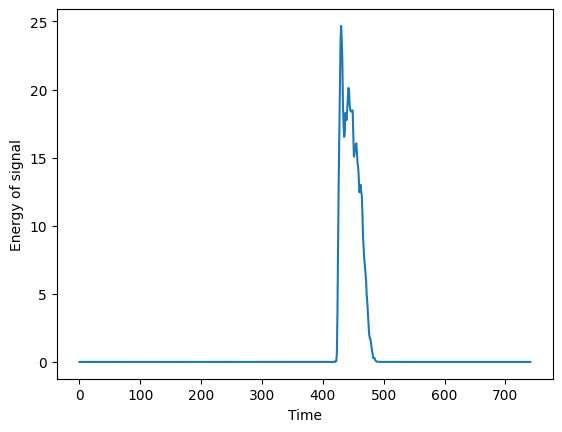

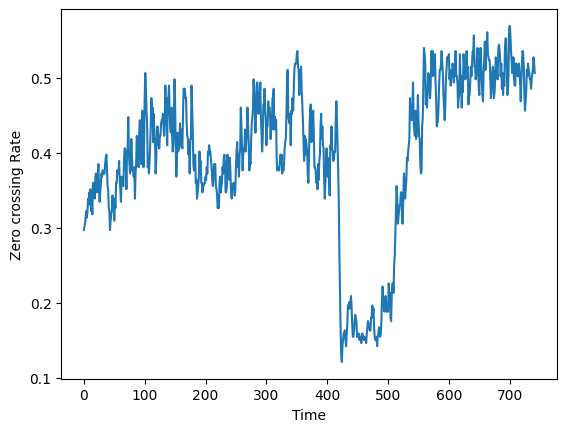

Computing MFCC features 

Output results of /content/drive/MyDrive/train/8a.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/7c.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



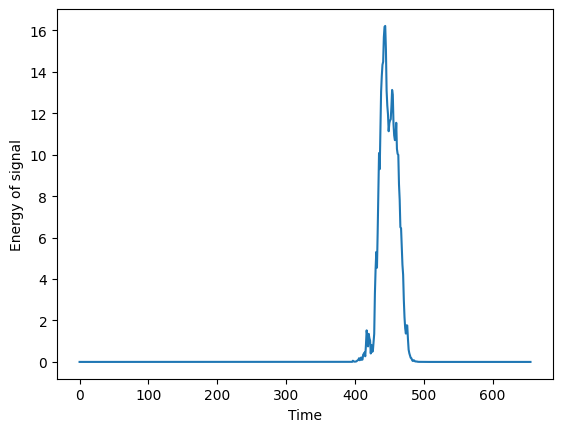

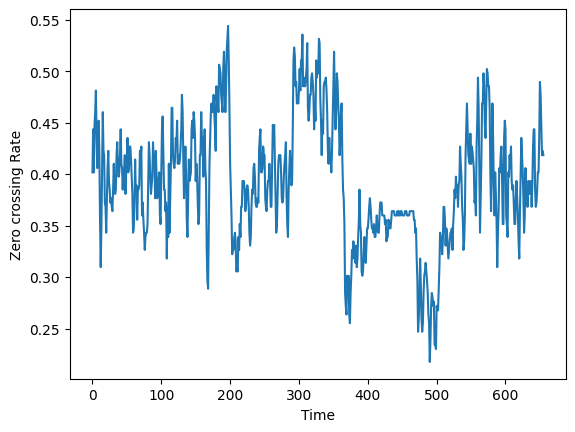

Computing MFCC features 

Output results of /content/drive/MyDrive/train/7c.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/6b.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



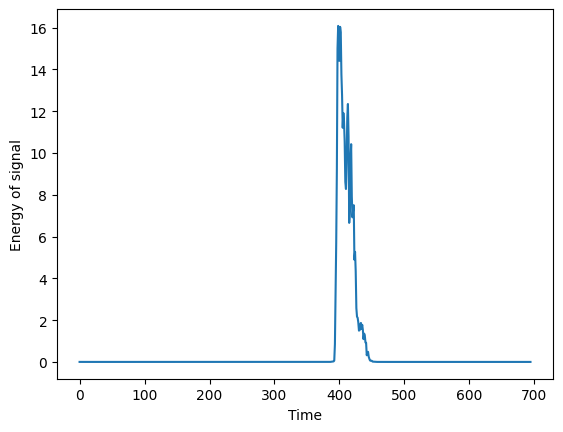

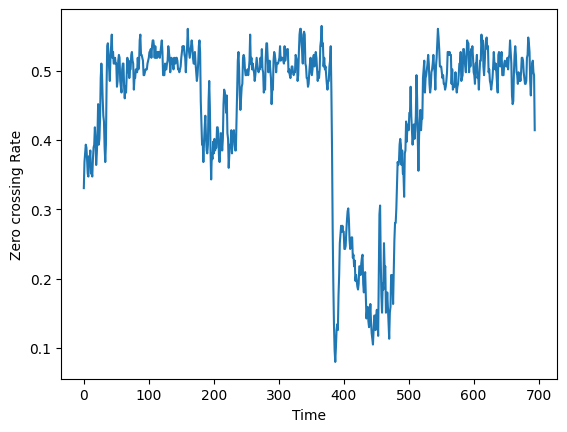

Computing MFCC features 

Output results of /content/drive/MyDrive/train/6b.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/9a.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



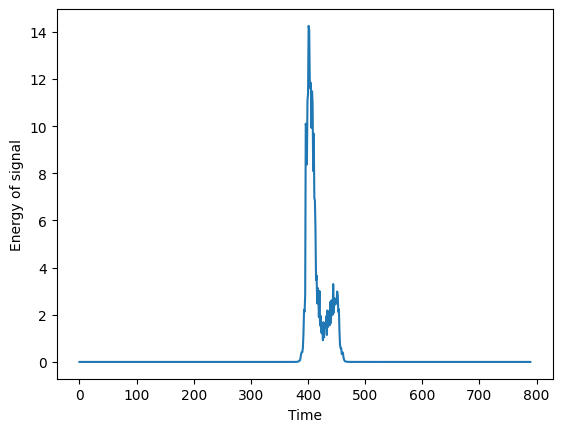

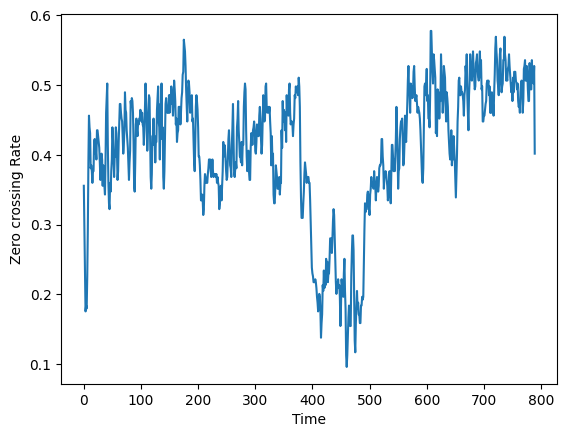

Computing MFCC features 

Output results of /content/drive/MyDrive/train/9a.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/9b.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



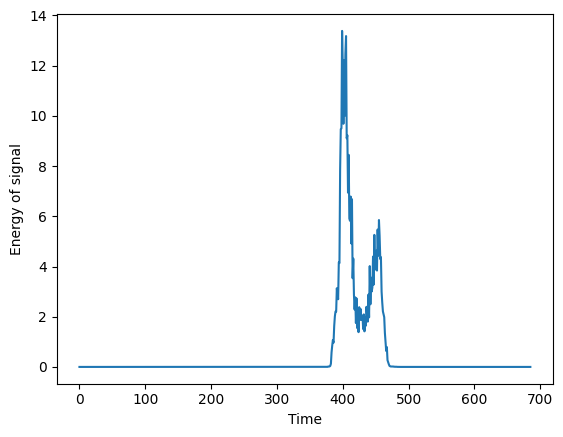

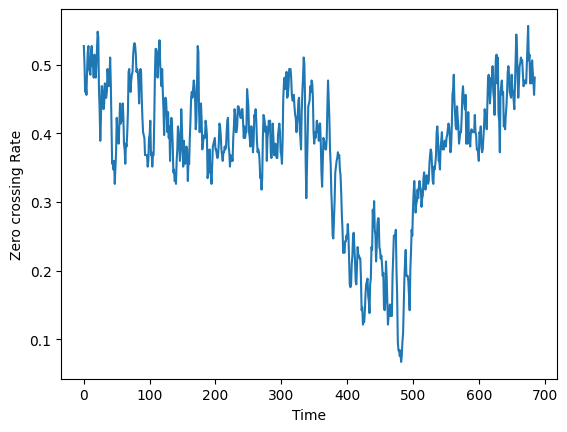

Computing MFCC features 

Output results of /content/drive/MyDrive/train/9b.wav  

_________________________________________________
Reading WAV file   /content/drive/MyDrive/train/9c.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



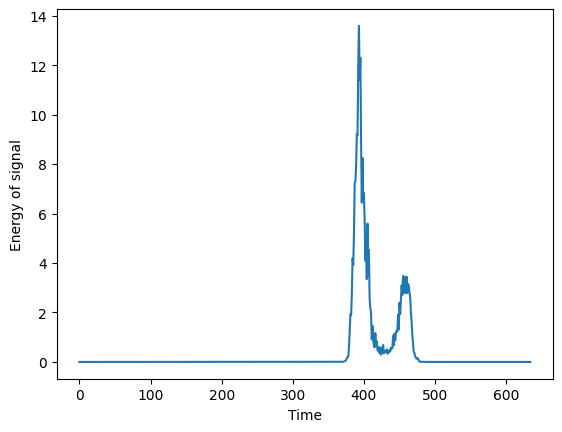

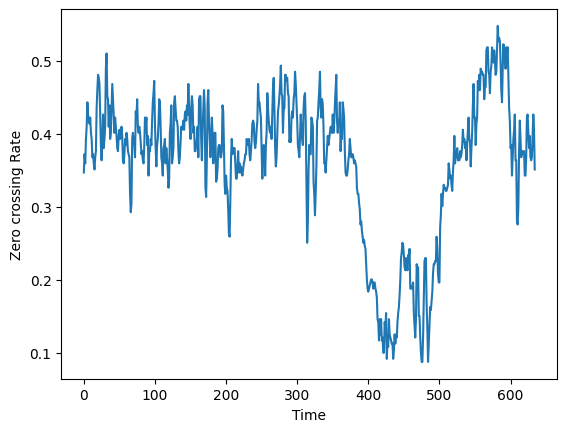

Computing MFCC features 

Output results of /content/drive/MyDrive/train/9c.wav  

_________________________________________________

 Training complete 



In [ ]:
import scipy.signal as signal
import numpy
import os

modelob = open("/content/drive/MyDrive/model.txt",'w')

for line in os.listdir("/content/drive/MyDrive/train"):
  if line.endswith(".wav"):
      #Get training file name
      label=line[0]
      filename="/content/drive/MyDrive/train/"+line
      #print(filename)
      #file reading
      wavearr=wavread(filename)
      #Signal pre-emphasis
      wavearr_pre=pre_emphasis(wavearr,0.98)
      #Select window function
      winfunc = signal.hamming(240)
      #Signal framing
      n=enframe(wavearr_pre,240,80,winfunc)
      #vad
      na=vioceextrac(n)
      #Extract features
      feat=mfcc(na,512)
      #Save features and criteria to the output model file
      print('Output results of',filename,' \n')
      print(label, file = modelob)
      print(feat, file = modelob)
      print("_________________________________________________")
      #print(numpy.shape(feat))
print('\n Training complete \n')
modelob.close()

### **Testing**

Actual Label :  2
Reading WAV file   /content/drive/MyDrive/test/2t.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



<ipython-input-2-38ef7c5dd080>:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  wave_data = np.fromstring(str_data, dtype=np.short)
<ipython-input-12-347b22e80d44>:19: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  winfunc = signal.hamming(240)


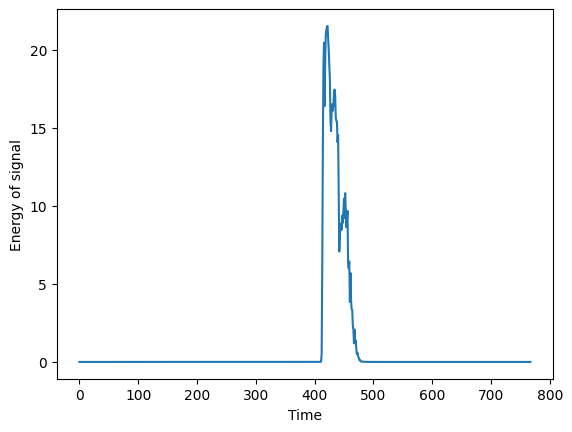

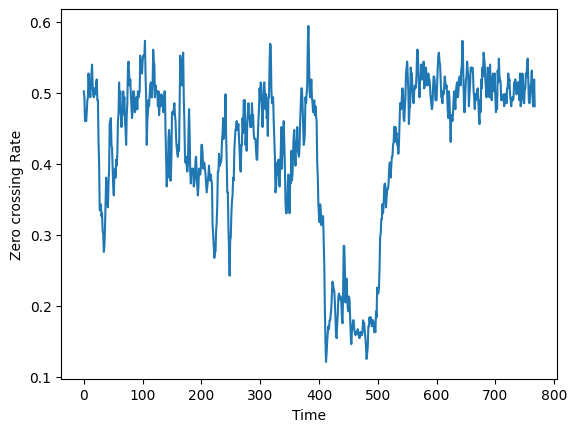

Computing MFCC features 

 DTW 

Min distance matching 

Output 

2
___________________________________________________
Actual Label :  1
Reading WAV file   /content/drive/MyDrive/test/1t.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



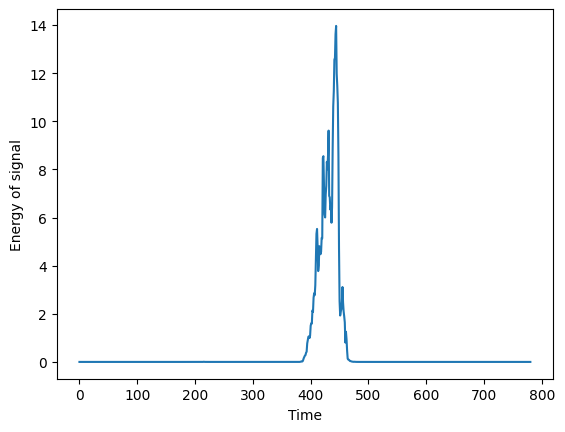

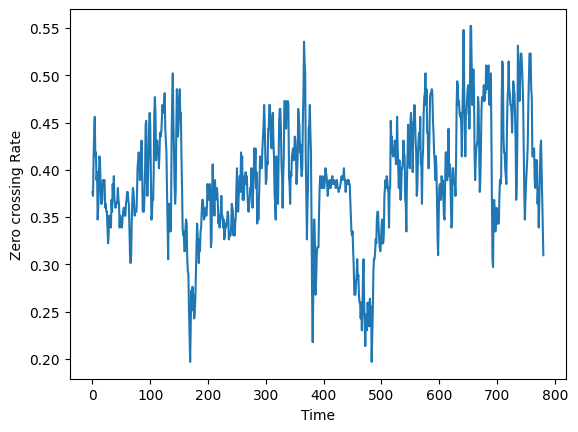

Computing MFCC features 

 DTW 

Min distance matching 

Output 

1
___________________________________________________
Actual Label :  0
Reading WAV file   /content/drive/MyDrive/test/0t.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



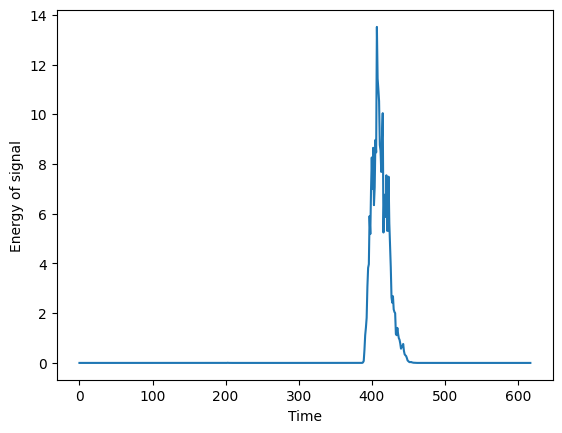

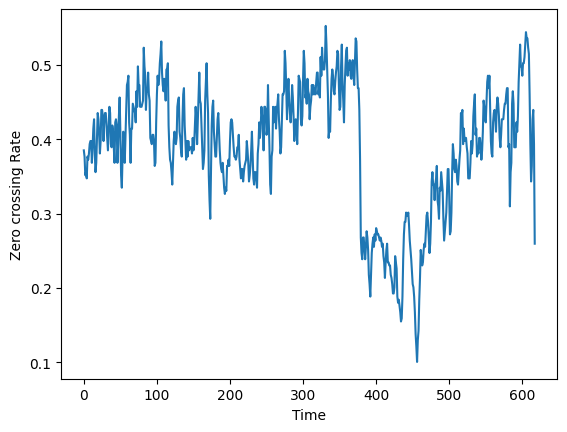

Computing MFCC features 

 DTW 

Min distance matching 

Output 

0
___________________________________________________
Actual Label :  4
Reading WAV file   /content/drive/MyDrive/test/4t.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



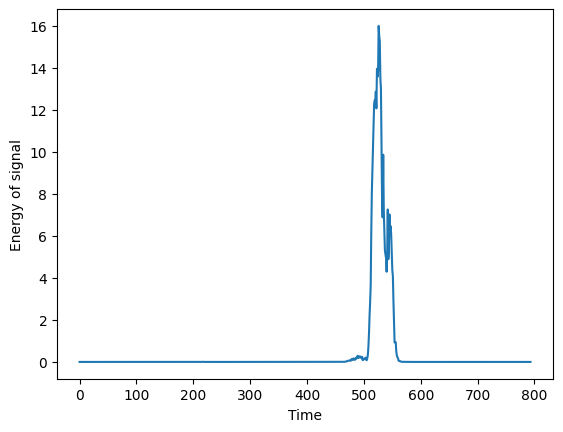

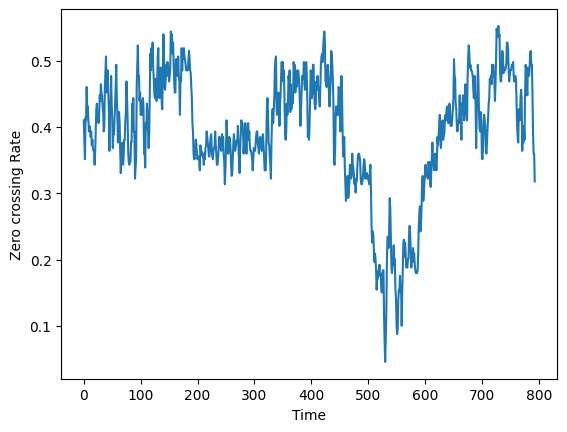

Computing MFCC features 

 DTW 

Min distance matching 

Output 

4
___________________________________________________
Actual Label :  3
Reading WAV file   /content/drive/MyDrive/test/3t.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



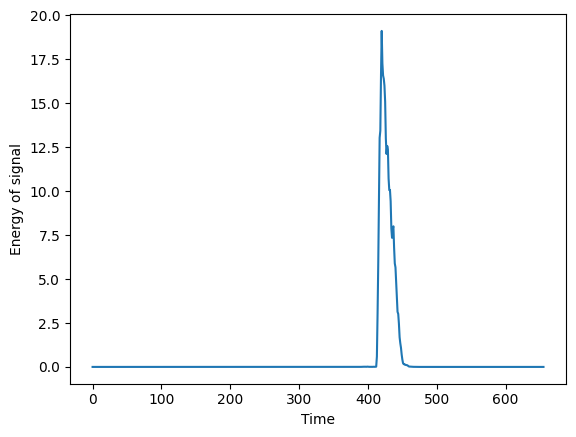

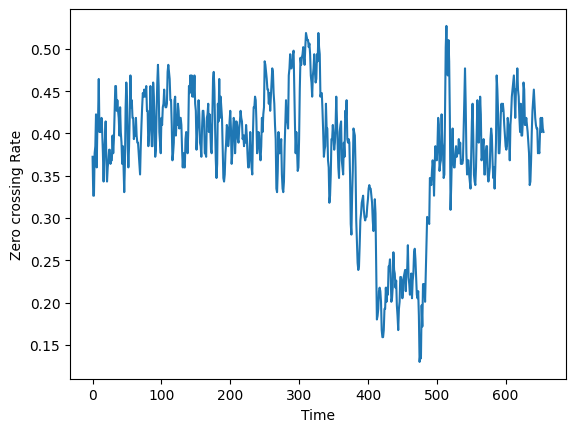

Computing MFCC features 

 DTW 

Min distance matching 

Output 

3
___________________________________________________
Actual Label :  8
Reading WAV file   /content/drive/MyDrive/test/8t.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



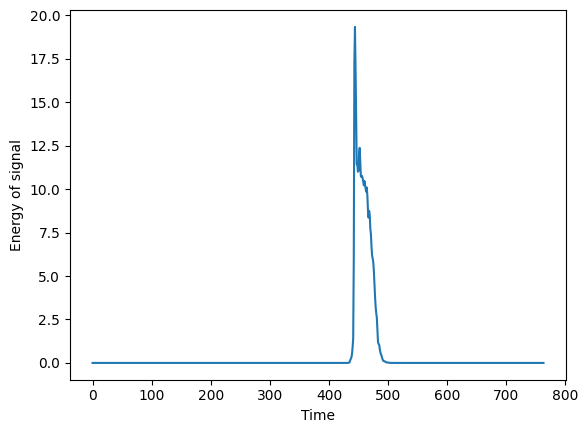

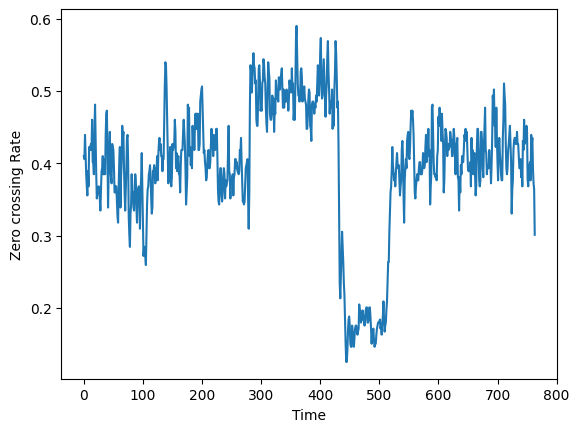

Computing MFCC features 

 DTW 

Min distance matching 

Output 

8
___________________________________________________
Actual Label :  9
Reading WAV file   /content/drive/MyDrive/test/9t.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



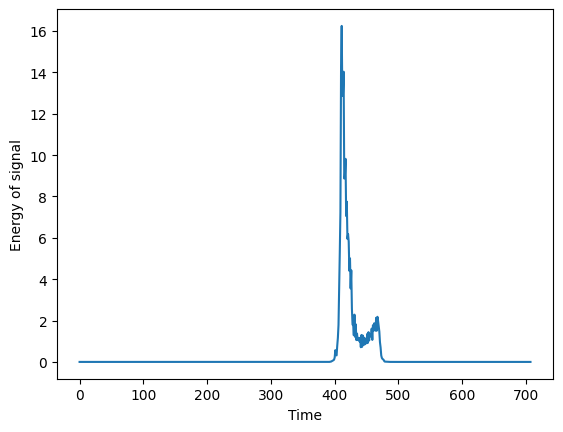

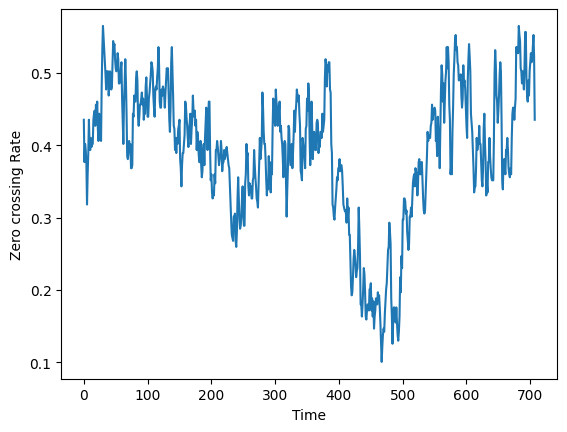

Computing MFCC features 

 DTW 

Min distance matching 

Output 

9
___________________________________________________
Actual Label :  6
Reading WAV file   /content/drive/MyDrive/test/6t.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



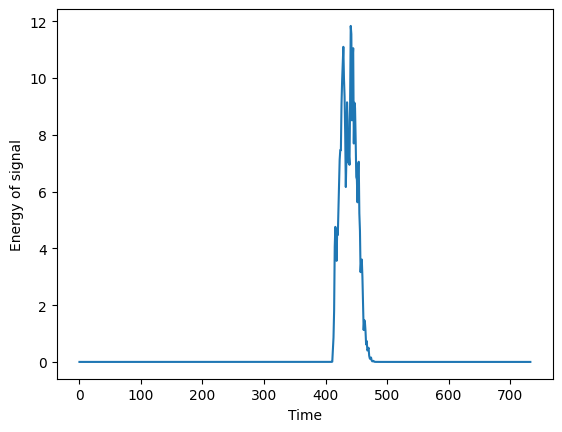

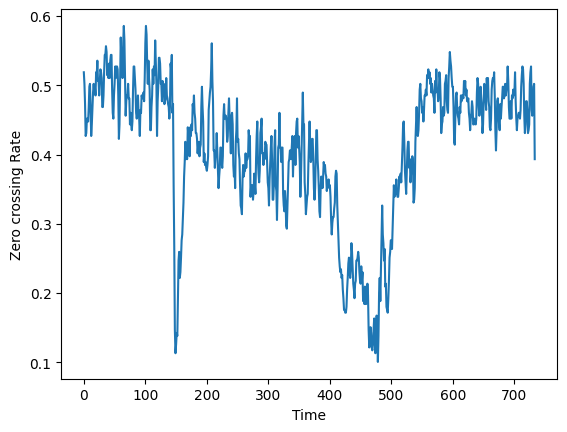

Computing MFCC features 

 DTW 

Min distance matching 

Output 

6
___________________________________________________
Actual Label :  7
Reading WAV file   /content/drive/MyDrive/test/7t.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



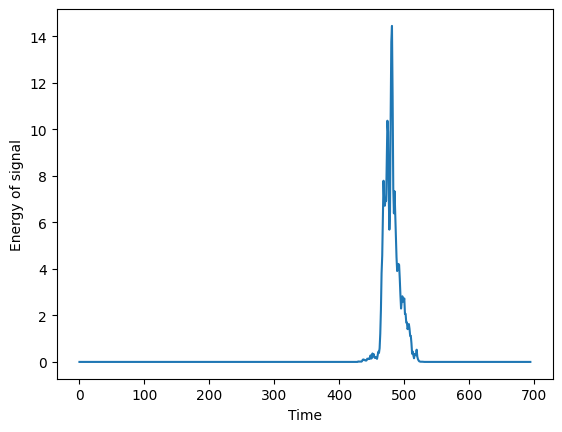

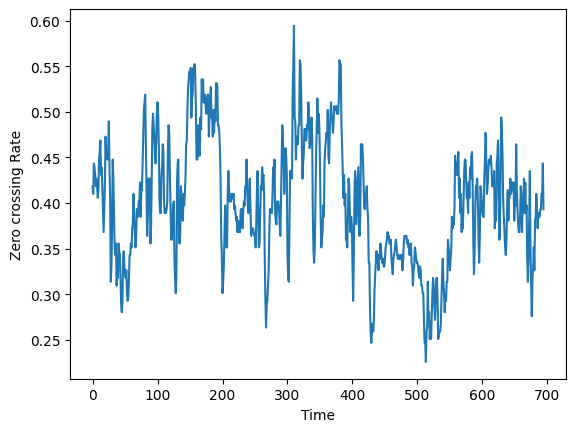

Computing MFCC features 

 DTW 

Min distance matching 

Output 

7
___________________________________________________
Actual Label :  5
Reading WAV file   /content/drive/MyDrive/test/5t.wav ---

Pre emphasis 

Signal framing and windowing 

Extracting active voice 



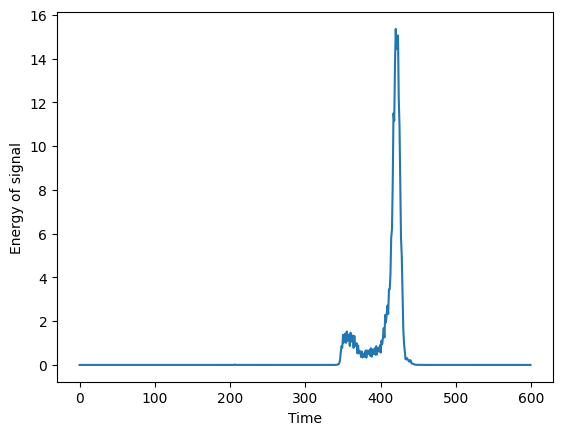

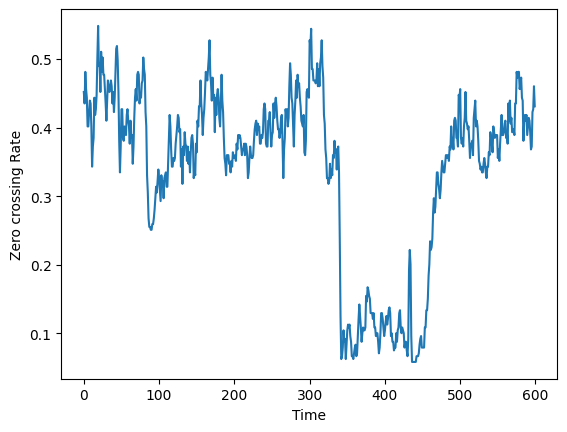

Computing MFCC features 

 DTW 

Min distance matching 

Output 

5
___________________________________________________
Test Accuracy : 100.0 %

 Recognition complete 



In [ ]:
import re
import scipy.signal as signal
import numpy
import os

total = 0
acc = 0
for line in os.listdir("/content/drive/MyDrive/test"):
  if line.endswith(".wav"):
    total += 1
    label=line[0]
    print("Actual Label : ", label)
    filename="/content/drive/MyDrive/test/"+line
    #file reading
    wavearr=wavread(filename)
    #Signal pre-emphasis
    wavearr_pre=pre_emphasis(wavearr,0.98)
    #Select window function
    winfunc = signal.hamming(240)
    #Signal framing
    n=enframe(wavearr_pre,240,80,winfunc)
    #vad
    na=vioceextrac(n)
    #Extract features
    feattest=mfcc(na,512)
    #print(numpy.shape(feattest))

    modelob=open("/content/drive/MyDrive/model1.txt")
    print(' DTW \n')
    i=0

    dist1=[]
    label=[]
    mframes=modelob.readlines()
    #print(len(frames))
    for line1 in mframes:
      i+=1
      mline=line1.strip()
      if i==1 and len(mline)==1:
          label.append(mline)

          featarr=[]
          nf=0                                                                                # No. of FVs extracted from each model
      if i>1 and len(mline)==1:
          #Regenerate numpy matrix and unify specifications
          feat=numpy.array(featarr,dtype=numpy.float64)
          feattrain=feat.reshape(nf,m)
          #print(feattrain)
          featarr=[]
          #Calculate the dtw distance from the test signal to each signal in the model
          dist1.append(score(feattrain,feattest))
          #print(nf,m)
          nf=0
          label.append(mline)

      if i!=len(mframes) and len(mline)>1:
          #print(mline)
          mline=mline.strip('[]')
          mline=mline.strip()
          #print(mline)
          mlinearr=re.split('\s+',mline)
          #print(len(mlinearr))
          #print(mlinearr)
          featarr.append(mlinearr)
          m=len(mlinearr)
          nf+=1
      if i==len(mframes) and len(mline)>1:
          #print(mline)
          mline=mline.strip('[]')
          mline=mline.strip()
          #print(mline)
          mlinearr=re.split('\s+',mline)
          #print(len(mlinearr))
          #print(mlinearr)
          featarr.append(mlinearr)
          m=len(mlinearr)
          nf+=1
          #Regenerate numpy matrix and unify specifications
          feat=numpy.array(featarr,dtype=numpy.float64)
          feattrain=feat.reshape(nf,m)
          #print(feattrain)
          featarr=[]
          #Calculate the dtw distance from the test signal to each signal in the model
          dist1.append(score(feattrain,feattest))
          #print(nf,m)
    if dist1 != []:
      print('Min distance matching \n')
      #Search for the smallest among all distances
      labelnum=dist1.index(min(dist1))
      print('Output \n')
      #Output the label corresponding to the minimum distance signal as the recognition result.
      print(label[labelnum])
      print("___________________________________________________")
      if line[0] == label[labelnum]:
        acc += 1
print("Test Accuracy :", (acc/total)*100, "%")
modelob.close
print('\n Recognition complete \n')